# Two-view reconstruction

A toy exercise to reconstruct the sparse 3D geometry of a scene from two arbitrary (non-stereo) images.

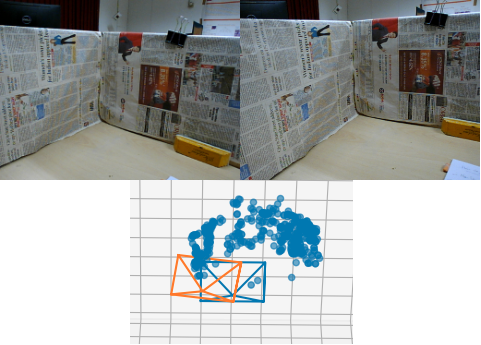

Concepts used:
- Feature extraction and matching
- Essential matrix
- Linear triangulation

@author: Karnik (karnikram@gmail.com)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_image(path):
    """ Loads image from the given path and returns
    it in grayscale format.
    """
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        print(path + ' could not be loaded!')
        
    return img

def extract_features(img):
    """ Extracts keypoints from the image and computes their descriptors.
    
    We use OpenCV's implementation of SIFT to do this.
    
    Args:
        img: The input grayscale image.
    
    Returns:
        kp: The detected keypoints.
        ds: The computed feature descriptors needed  for matching.      
    """
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000)
    kp, des = sift.detectAndCompute(img, None)
    
    return kp, des

def match_features(kp1, kp2, des1, des2):
    """ Matches keypoints from two images using their descriptors.
    
    We use OpenCV's implementation of brute-force matching to do this.
    
    Args:
        kp1: Detected keypoints from the first image.
        kp2: Detected keypoints from the second image.
        des1: Descriptors of the keypoints from the first image.
        des2: Descriptors of the keypoints from the second image.
        
    Returns:
        matches: List of DMatch objects needed for visualization.
        pts1: The 2d image coordinates of matched keypoints from first image.
        pts2: The 2d image coordinates of matched keypoints from second image.
    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    
    pts1 = []
    pts2 = []

    for match in matches:
        pts1.append(kp1[match.queryIdx].pt)
        pts2.append(kp2[match.trainIdx].pt)
        
    pts1 = np.array(pts1, dtype=np.float32)
    pts2 = np.array(pts2, dtype=np.float32)
    
    return matches, pts1, pts2

def find_essentialmat(K, pts1, pts2):
    """ Finds the essential matrix between two views given matching points.
    
    We use OpenCV's implementation of the five-point algorithm for estimating the matrix.
    The estimation is wrapped inside a RANSAC scheme for robustness against incorrect matches.
    
        Args:
            K: Camera calibration matrix.
            pts1: nx2 image points from first image.
            pts2: nx2 matching image points from second image.
            
        Returns:
            E: The essential matrix.
            pts1: nx2 _inlier_ image points from first image.
            pts2: nx2 _inlier_ image points from second image.
    """
    
    E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1)

    mask = mask[:,0]
    m_pts1 = []
    m_pts2 = []
    for idx, pt in enumerate(pts1):
        if(mask[idx]):
            m_pts1.append(pts1[idx,:])
            m_pts2.append(pts2[idx,:])

    pts1 = np.array(m_pts1)
    pts2 = np.array(m_pts2)
    
    return E, pts1, pts2

def make_homogeneous_pose(R, t):
    """ Constructs a 4x4 homogeneous transformation matrix from a 3x3 rotation matrix
    and a 3x1 translation vector.
    """
    return np.concatenate((np.concatenate((R,t),axis=1),np.array([[0,0,0,1]])),axis=0)

### Input

We've provided you two images of a scene that we want to reconstruct.
These two images, however, need to be from a calibrated camera i.e. a camera whose internal parameters have already been estimated. (**Q**: What are these internal parameters?)

Recall that to estimate these parameters we use multiple images of a known pattern. Images of one such pattern taken from the same camera have been provided in `../calibration/`. Run the provided `../calibration/calib.py` script on these images to estimate this camera's internal parameters.

In [ ]:
######## TODO #########
K = np.array([[?, ?, ?],
              [?, ?, ?],
              [?, ?, ?]])


img1 = load_image('./img1.png')
img2 = load_image('./img2.png')

### Feature extraction

Next, we identify a few salient points (or 'keypoints') from the images that will help us to estimate the camera motion between the two images. Here, we extract these keypoints using the `extract_features` function and then we visualize them. Notice that almost no keypoints belong to the table surface.

In [ ]:
kp1, des1 = extract_features(img1)
kp2, des2 = extract_features(img2)

fix, ax = plt.subplots(1,2)
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

for idx in range(len(kp1)):
    ax[0].plot(kp1[idx].pt[0], kp1[idx].pt[1], 'r*')
    
for idx in range(len(kp2)):
    ax[1].plot(kp2[idx].pt[0], kp2[idx].pt[1], 'b*')

### Feature matching

We now wish to match these extracted keypoints from both the images. That is, we want to identify keypoints from both the images that correspond to the same 3D point in the scene. Here, we do this by matching the feature descriptor vectors using the `match_features` function and then we visualize the matches. Notice that there are some incorrect matches.

In [ ]:
matches, pts1, pts2 = match_features(kp1, kp2, des1, des2)
draw_params = dict(matchColor = (0,255,0), singlePointColor=(255,0,0), flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.imshow(img3)

### Estimating camera motion

Next, we estimate the camera motion between the two frames by estimating the corresponding essential matrix. Recall that the essential matrix is a 3x3 matrix that encodes the relative orientation between two calibrated views.

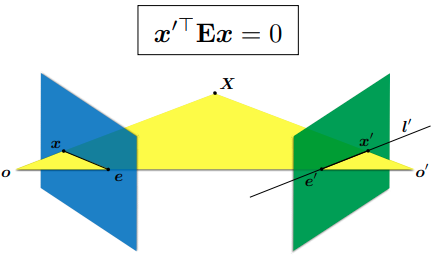

[Img. courtesy: Kitani]

**Q** What is the difference between the essential matrix and a homography matrix?

Also recall that $\mathrm{E} = [\mathrm{t}]_\times \mathrm{R}$, where $\mathrm{t}$ and $\mathrm{R}$ are the relative translation and rotation between the two views respectively. Hence we can estimate the relative transformation between the two views by first estimating their associated essential matrix, and then decomposing the matrix into its constituent rotation and translation.

In [ ]:
E, pts1, pts2 = find_essentialmat(K, pts1, pts2)
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

Once we obtain the relative transformation, we construct the camera matrices $\mathrm{P_1}$ and $\mathrm{P_2}$ as $\mathrm{P_1} = \mathrm{K}[\mathrm{I} | 0]$ and $\mathrm{P_2} = \mathrm{K}[\mathrm{R} | \mathrm{t}]$

In [ ]:
T = make_homogeneous_pose(R,t)
P1 = np.concatenate((K,np.array([[0],[0],[0]])),axis=1)
P2 = K @ T[:-1,:]

We then visualize the estimated relative transformation by plotting the camera matrices as simple 3D frustrums.

In [ ]:
cam_frustrum = np.array([[-1,-1,1,1],
               [1,-1,1,1],
               [1,1,1,1],
               [-1,1,1,1],
               [-1,-1,1,1],
               [0,0,0,1],
               [1,-1,1,1],
               [1,1,1,1],
               [0,0,0,1],
               [-1,1,1,1]])

cam_frustrum1 = cam_frustrum

cam_frustrum2 = (T @ cam_frustrum.transpose()).transpose()

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

ax.plot(cam_frustrum1[:,0], cam_frustrum1[:,1], cam_frustrum1[:,2])
ax.plot(cam_frustrum2[:,0], cam_frustrum2[:,1], cam_frustrum2[:,2])

### Triangulation

Once we have matching image points, and the estimated relative transformation between the two views, we can triangulate the corresponding 3D points. This can be done geometrically, by simply considering the rays corresponding to each matching image point and finding their intersection in 3D.

Or, we can do this algebraically which is easier to implement.

Consider two matching image points $x_1$ and $x_2$ which correspond to the same 3D point $\mathrm{X}$ in the scene. We know $x_1 = \mathrm{P_1}\mathrm{X}$ and $x_2 = \mathrm{P_2}\mathrm{X}$. From these two equations we can form a homogeneous sytem of the form $\mathrm{A}\mathrm{X} = 0$ where $$A = \begin{pmatrix}u_1p_1^{3T} - p_1^{1T}\\v_1p_1^{3T} - p_1^{2T}\\u_2p_2^{3T} - p_2^{1T}\\v_2p_2^{3T} - p_2^{2T}\end{pmatrix}$$ $P_1^{1T}$ is the first row of $\mathrm{P1}$, $(u_1, v_1)$ are the image coordinates in the first image and so on. Recall that we can solve for this vector $\mathrm{X}$ by finding the singular vector of $\mathrm{A}$ that corresponds to the smallest singular value. This gives us the 3D point $\mathrm{X}$.

We can then repeat this for all image points and obtain a full sparse 3D point cloud as shown below.

In [ ]:
def triangulate_points(P1, P2, pts1, pts2):
    """ Estimates the triangulated 3D points from matching image points and
    the corresponding camera matrices using algebraic triangulation.
    
    Args:
        P1: 3x4 first camera matrix.
        P2: 3x4 second camera matrix.
        pts1: nx2 image points from first image.
        pts2: nx2 matching image points from second image.
        
    Returns:
        pts_3d: Triangulated 3D points
        
    """
    print('Write me!')
    
    return None

In [ ]:
pts_3d = triangulate_points(P1, P2, pts1, pts2)

################ OR #################

#pts_3d = cv2.triangulatePoints(P1, P2, pts1.transpose(), pts2.transpose())
#pts_3d = pts_3d/pts_3d[-1,:]

### Visualization

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-5,5)
ax.set_ylim3d(-5,5)
ax.set_zlim3d(-5,5)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

ax.scatter(pts_3d[0,:],pts_3d[1,:],pts_3d[2,:])
ax.plot(cam_frustrum1[:,0], cam_frustrum1[:,1], cam_frustrum1[:,2])
ax.plot(cam_frustrum2[:,0], cam_frustrum2[:,1], cam_frustrum2[:,2])